# Prologue

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans

## definitions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## data

In [3]:
path = 'data/credit_card.csv'
df = pd.read_csv(path)
orginal_df = df.copy()
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [4]:
# In this assignment, you will use anomaly detection techniques to detect credit card fraud using this modified dataset originally from Kaggle.  Each row represents one credit card transaction.  This dataset has anonymized features, except for the amount of the transaction.  

# Your stakeholder reports that they have found that about 0.4% of transactions are fraudulent, and 99.6% are valid.  

# Your task will be to locate anomalous transactions in this data using KMeans and IsolationForest models  

# KMeans

Remember to scale your data.

In [5]:
scaler = StandardScaler().fit(df)
X = scaler.transform(df)
X = pd.DataFrame(X, columns=df.columns)
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.726092,-0.270865,1.389980,0.762227,-0.236899,0.264052,0.285346,0.131083,-0.384443,0.286120,-1.133169,0.446834,-1.535047,-0.821518,1.645946,-0.517249,-0.133250,0.057508,0.585590,0.370795,0.043066,0.689788,-0.163478,0.083851,0.099198,-0.532722,0.312929,-0.090009,0.459472
1,0.949810,-0.013020,-0.647336,0.110710,0.102482,-0.155239,-0.009963,0.120253,-0.915428,0.051569,0.722785,1.551943,-0.315973,-0.686699,0.798096,0.541269,-0.466837,-0.205886,-0.093585,-0.167706,-0.185510,-0.760673,0.268858,-0.603364,0.188884,0.033761,-0.039088,0.043500,-0.333835
2,-0.725138,-1.235035,0.733929,0.062810,-0.377373,1.293991,0.797185,0.249752,-1.995239,0.392444,-0.124638,0.895884,-0.128068,-0.704557,2.539689,-3.258583,0.798958,-0.127804,-2.707713,0.830447,0.336466,1.471338,1.918734,-1.193707,-0.959876,-0.442774,-0.153601,-0.234422,1.696110
3,-0.467623,-0.356408,0.750937,-0.808030,0.042565,0.868121,0.283501,0.353112,-1.885794,0.153501,-0.854378,0.969520,-0.300606,-0.802796,-0.492057,-1.184825,-1.055192,2.500622,-1.436230,-0.401179,-0.056083,0.258431,-0.326493,-2.015264,1.303733,-0.591732,0.137995,0.217896,0.318445
4,-0.593701,0.452248,0.540940,0.079101,-0.295578,-0.018016,0.613062,-0.163028,0.004829,0.888749,-1.365765,1.205880,0.389505,-1.472671,0.329236,-0.495778,-0.593159,-0.023071,1.079111,0.634808,0.052846,1.513434,-0.218569,0.209441,-0.677493,0.710640,0.524976,0.791442,0.029532


In [6]:
# Fit a KMeans model to create 3 clusters.  Please use a random state of 42 for your model.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans.fit(X)

KMeans(n_clusters=3, n_init=20, random_state=42)

In [7]:
# Use scipy.spatial.distance.cdist to create a matrix of distances between each data point and each cluster center
from scipy.spatial.distance import cdist
distances = cdist(df, kmeans.cluster_centers_, 'euclidean')
distances.shape
# df.shape

(10000, 3)

In [8]:
cluter_cols = [f"Distance (Cluster {c})" for  c in range(len(kmeans.cluster_centers_))]
distance_df = pd.DataFrame(distances, columns = cluter_cols)
distance_df.head(3)


,Distance (Cluster 0),Distance (Cluster 1),Distance (Cluster 2)
0,149.686035,149.663870,151.415509
1,3.997380,4.217804,20.408510
2,378.718767,378.697994,379.586494


In [9]:
# Get the minimum distance to any cluster for each point
min_distances = np.min(distances, axis=1)

# Display first 5 values
min_distances[:5]

array([149.66386988,   3.99738028, 378.69799409, 123.56898837,
        70.08454881])

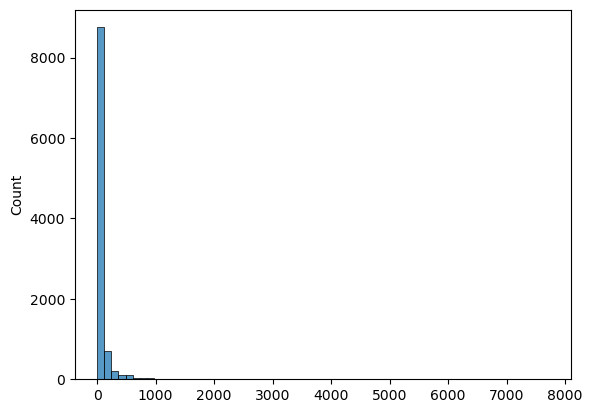

In [10]:
ax = sns.histplot(min_distances, bins=64)

In [11]:
# Set a threshold based on a percentile
threshold = np.percentile(min_distances, 99.6)
threshold

1129.1575218259882

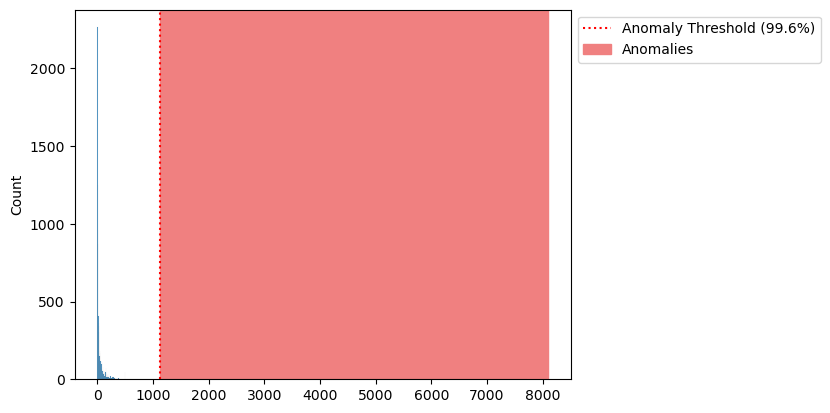

In [12]:
# Visualize the distribution of distances and the anomaly threshold.
ax = sns.histplot(min_distances)
ax.axvline(threshold, color='red', ls=':', label='Anomaly Threshold (99.6%)')
ax.axvspan(threshold, ax.get_xlim()[1], color='lightcoral',zorder=0, label='Anomalies')
ax.legend(bbox_to_anchor=[1,1]);

Define a list of the indices of the anomalous data using the threshold given by the stakeholder (99.6% valid).


In [13]:
# Identify anomalies where the distance to closest cluster center is above the threshold
filter_anomalies = min_distances > threshold
# how many were found?
filter_anomalies.sum()

40

In [14]:
# Getting the row indices of the anomalies
idx_anomalies = X[filter_anomalies].index
idx_anomalies

Int64Index([  49,   87,  159,  857, 1019, 1271, 1376, 1412, 1619, 2156, 2363,
            2428, 2594, 2649, 3103, 3618, 3674, 4026, 4280, 4612, 4939, 5490,
            5517, 5538, 5581, 5811, 6643, 6829, 7096, 7322, 7338, 7453, 7470,
            7615, 7631, 8226, 8299, 8696, 9417, 9699],
           dtype='int64')

In [26]:
# Slicing the anomalies from X
X.iloc[idx_anomalies].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 49 to 9699
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      40 non-null     float64
 1   V2      40 non-null     float64
 2   V3      40 non-null     float64
 3   V4      40 non-null     float64
 4   V5      40 non-null     float64
 5   V6      40 non-null     float64
 6   V7      40 non-null     float64
 7   V8      40 non-null     float64
 8   V9      40 non-null     float64
 9   V10     40 non-null     float64
 10  V11     40 non-null     float64
 11  V12     40 non-null     float64
 12  V13     40 non-null     float64
 13  V14     40 non-null     float64
 14  V15     40 non-null     float64
 15  V16     40 non-null     float64
 16  V17     40 non-null     float64
 17  V18     40 non-null     float64
 18  V19     40 non-null     float64
 19  V20     40 non-null     float64
 20  V21     40 non-null     float64
 21  V22     40 non-null     float64
 22  V

In [16]:
df = X.copy()
df['cluster'] = kmeans.predict(X)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,cluster
0,-0.726092,-0.270865,1.389980,0.762227,-0.236899,0.264052,0.285346,0.131083,-0.384443,0.286120,-1.133169,0.446834,-1.535047,-0.821518,1.645946,-0.517249,-0.133250,0.057508,0.585590,0.370795,0.043066,0.689788,-0.163478,0.083851,0.099198,-0.532722,0.312929,-0.090009,0.459472,1
1,0.949810,-0.013020,-0.647336,0.110710,0.102482,-0.155239,-0.009963,0.120253,-0.915428,0.051569,0.722785,1.551943,-0.315973,-0.686699,0.798096,0.541269,-0.466837,-0.205886,-0.093585,-0.167706,-0.185510,-0.760673,0.268858,-0.603364,0.188884,0.033761,-0.039088,0.043500,-0.333835,1
2,-0.725138,-1.235035,0.733929,0.062810,-0.377373,1.293991,0.797185,0.249752,-1.995239,0.392444,-0.124638,0.895884,-0.128068,-0.704557,2.539689,-3.258583,0.798958,-0.127804,-2.707713,0.830447,0.336466,1.471338,1.918734,-1.193707,-0.959876,-0.442774,-0.153601,-0.234422,1.696110,1
3,-0.467623,-0.356408,0.750937,-0.808030,0.042565,0.868121,0.283501,0.353112,-1.885794,0.153501,-0.854378,0.969520,-0.300606,-0.802796,-0.492057,-1.184825,-1.055192,2.500622,-1.436230,-0.401179,-0.056083,0.258431,-0.326493,-2.015264,1.303733,-0.591732,0.137995,0.217896,0.318445,1
4,-0.593701,0.452248,0.540940,0.079101,-0.295578,-0.018016,0.613062,-0.163028,0.004829,0.888749,-1.365765,1.205880,0.389505,-1.472671,0.329236,-0.495778,-0.593159,-0.023071,1.079111,0.634808,0.052846,1.513434,-0.218569,0.209441,-0.677493,0.710640,0.524976,0.791442,0.029532,1


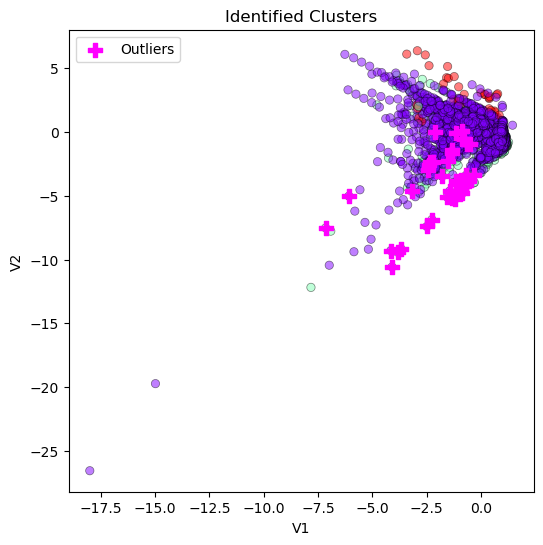

In [17]:
# Plot the data points and identified clusters
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    df["V1"], df["V2"], c=df["cluster"], ec="black", lw=0.5, cmap="rainbow", alpha=0.5
)
ax.set(xlabel="V1", ylabel="V2", title="Identified Clusters")
## Plotting the anomalies for visibility.
X.iloc[idx_anomalies].plot(
    x="V1", y="V2", kind="scatter", color="magenta", label="Outliers", ax=ax, marker='P',s=100,
);

Note that you cannot visualize your clusters since this dataset has 29 features. (To visualize, you could apply PCA to reduce the dimensionality to 2 features, but visualization is not required.) 


# 2. Isolation Forest:


In [23]:
# Note: If you added any columns to the original dataset in the previous step, be sure to exclude them before fitting your Isolation Forest.

In [18]:
df_2 = orginal_df.copy()
df_2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Fit

In [19]:
from sklearn.ensemble import IsolationForest
# Instantiate the model with a contaimination of 0.0004
iso_0004 = IsolationForest(contamination=0.004, random_state = 42)

# fit the model using .values to avoid a warning
iso_0004.fit(X.values)

IsolationForest(contamination=0.004, random_state=42)

In [ ]:
# Instantiate and fit an Isolation Forest with the correct contamination value based on the threshold given by the stakeholder (Be careful: 0.4% = 0.004). Please use a random state of 42 for your model.

from sklearn.ensemble import IsolationForest
# Instantiate the model with a contaimination of 0.0004
iso_0004 = IsolationForest(contamination=0.004, random_state=42)

# fit the model using .values to avoid a warning
iso_0004.fit(X.values)

Predict

In [20]:
# Predict the anomalies
predictions = iso_0004.predict(X.values)
predictions.sum()

9920

In [25]:
# Change the labels to match our columns from the kmeans dataframe
# Not anamolies
predictions[predictions == 1] = 0
# Anomalies
predictions[predictions == -1] = 1
# Preview new labels
predictions.sum()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
# Add isolation forest predictions to the dataframe
df_2['anomaly-iso_0004'] = predictions
# Preview dataframe with new column
df_2.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly-iso_0004
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Define a list of the indices of anomalous data.  Remember that anomalies are marked as -1, and normal data is marked as 1.

# 3. Compare the list of anomalies from KMeans and Isolation Forest.  

# Once you have a list of indices from each model, you can use list comprehension to find the points in common. For example:
# # Make a list of anomolies identified in both methods
# both = [a for a in iso_anomalies if a in kmeans_anomalies]
# copy
# Answer the following:
# a. How many anomalies did the two approaches agree on?
# b. What percentage of the anomalies did the two approaches agree on?

### Step 2:

#### Substep 2.1:

#### Substep 2.2:

#### Substep 2.3:

### Step 3:

#### Substep 3.1:

#### Substep 3.2:

# Questions

## Question 1

## Question 2

## Question 3

In [24]:
# trim whitespace from markdown cells

# import nbformat as nbf

# def trim_whitespace_in_notebook(notebook_path):
#     # Read the notebook
#     with open(notebook_path) as f:
#         nb = nbf.read(f, as_version=4)

#     # Iterate over all cells
#     for cell in nb.cells:
#         # Check if the cell is a markdown cell
#         if cell.cell_type == 'markdown':
#             # Trim leading and trailing whitespace from the cell content
#             cell.source = cell.source.strip()

#     # Write the modified notebook back to the file
#     with open(notebook_path, 'w') as f:
#         nbf.write(nb, f)

# # Use the function
# trim_whitespace_in_notebook('W1-C1 PCA Exercise (Core).ipynb')